# Convolutional Neural Network on Fashion MNIST
---
Don't forget to use **https://pytorch.org/docs/stable/**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

---

## Intro to convolutional filters

In [4]:
from image_processing_workshop.utils import get_image_from_url
from image_processing_workshop.visual import plot_image
import numpy as np
import matplotlib.pylab as plt

### Download your favouirite image

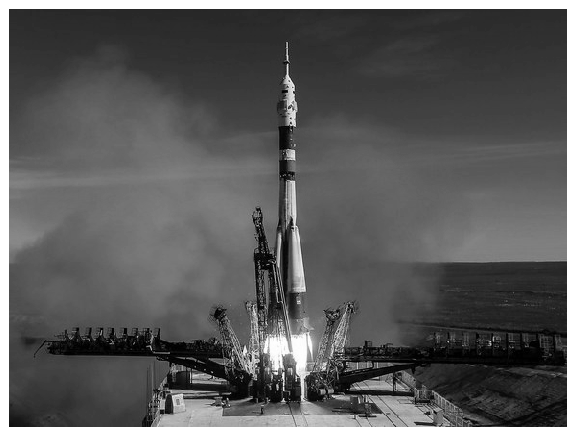

In [3]:
url = 'https://media.wired.com/photos/5bbf72c46278de2d2123485b/master/w_582,c_limit/soyuz-1051882240.jpg'
img = get_image_from_url(url, to_grayscale=True)
img = img / 255.
plot_image(img)

### Explore prepared filters

In [5]:
initial_filter = np.array([[-1, -1, 1, 1], 
                           [-1, -1, 1, 1], 
                           [-1, -1, 1, 1], 
                           [-1, -1, 1, 1]])
filter_1 = initial_filter
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

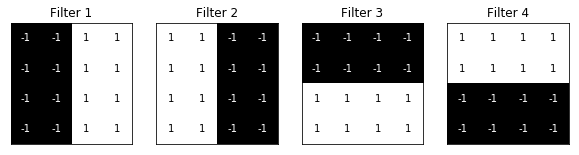

In [6]:
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))
    width, height = filters[i].shape
    
    # Add -1 1 annotations to image.
    for x in range(width):
        for y in range(height):
            ax.annotate(str(filters[i][x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filters[i][x][y]<0 else 'black')

### Build small network initialised with those filters
In the examples, we will use `torch.nn.conv2d` https://pytorch.org/docs/stable/nn.html#conv2d

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
filters_torch = torch.from_numpy(filters).unsqueeze(1).type(torch.DoubleTensor)
filters_torch.shape

torch.Size([4, 1, 4, 4])

In [9]:
img_torch = torch.from_numpy(img).unsqueeze(0).unsqueeze(1)
img_torch.shape

torch.Size([1, 1, 436, 582])

Convoluton filters efectively change height and width of input image that

$H_{out} = \lfloor \frac{H_{in}+2×padding[0]−dilation[0]×(kernel\_size[0]−1)−1}{stride[0]} +1 \rfloor$   
$W_{out} = \lfloor \frac{W_{in}+2×padding[1]−dilation[1]×(kernel\_size[1]−1)−1}{stride[1]} +1 \rfloor$



In [10]:
class ConvNeuralNetSimple(nn.Module):    
    def __init__(self, filters_torch):
        super(ConvNeuralNetSimple, self).__init__()
        
        height, width = filters_torch.shape[2:]
        self.conv_layer = nn.Conv2d(in_channels=1, out_channels=4, 
                                    kernel_size=(height, width), bias=False)
        self.conv_layer.weight.data = filters_torch

    def forward(self, images):
        return self.conv_layer(images)
    
conv_neural_net_simple = ConvNeuralNetSimple(filters_torch)
print(conv_neural_net_simple)
print(list(conv_neural_net_simple.parameters()))

ConvNeuralNetSimple(
  (conv_layer): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
[Parameter containing:
tensor([[[[-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.]]],


        [[[ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.]]],


        [[[-1., -1., -1., -1.],
          [-1., -1., -1., -1.],
          [ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.]]],


        [[[ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.],
          [-1., -1., -1., -1.],
          [-1., -1., -1., -1.]]]], dtype=torch.float64, requires_grad=True)]


In [11]:
img_torch.shape

torch.Size([1, 1, 436, 582])

In [12]:
feature_maps = conv_neural_net_simple(img_torch)
feature_maps.shape

torch.Size([1, 4, 433, 579])

### Visualization of conv layer feature maps

In [13]:
def vizualize_feature_maps(feature_maps, n_maps= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_maps):
        ax = fig.add_subplot(1, n_maps, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(feature_maps[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

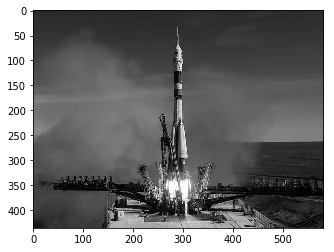

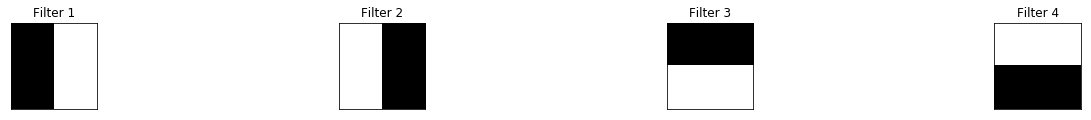

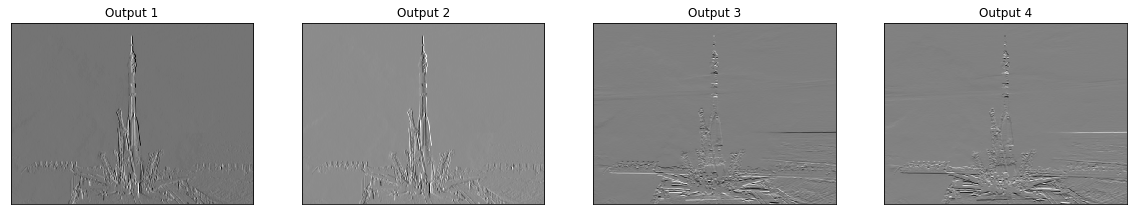

In [14]:
# Source img.
plt.imshow(img, cmap='gray')

# Convolution filters.
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

# Feature maps.    
vizualize_feature_maps(feature_maps)

### Sensitivity of image on convolution filters

In [15]:
from ipywidgets import interactive
import ipywidgets as ipw

In [16]:
feature_map = feature_maps[0][0].detach().numpy()
feature_map.shape

(433, 579)

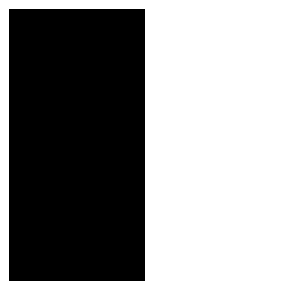

In [19]:
plot_image(filter_1, figsize=(5,5))

In [ ]:
feature_map_max = feature_map.max()
def plot_sensitivity(tolerance):
    feature_map_filtered = (feature_map >= (feature_map_max - tolerance)).astype(int)
    fig = plt.figure(figsize=(10, 10))
    im = plt.imshow(feature_map_filtered, cmap='gray')
    plt.colorbar(im, orientation='horizontal')
    plt.gca().axes.set_axis_off()
    plt.show()
    
interactive(plot_sensitivity, tolerance=ipw.FloatSlider(0.5, min=0, max=feature_map_max - 0.1, step=0.01))

---

## Prepare Fashion MNIST dataset

In [21]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Compose
from torch.utils.data import DataLoader

In [22]:
transformations = Compose([ToTensor()])

train_dataset = FashionMNIST('./dataset_fashion_mnist/', download=True, train=True, transform=transformations, target_transform=None)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataset = FashionMNIST('./dataset_fashion_mnist/', download=True, train=False, transform=transformations, target_transform=None)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [23]:
valid_dataset[0][0].shape

torch.Size([1, 28, 28])

## Define convolutional neural network

### Architecure

In [24]:
from torch.nn import Module, Sequential
from torch.nn import ReLU, Tanh, Dropout, Softmax, Linear, Conv2d, MaxPool2d, BatchNorm2d
from torch.nn import MSELoss, CrossEntropyLoss, NLLLoss
from torch.optim import Adam, SGD
from torch.nn.init import xavier_uniform_, normal_

In [60]:
class ConvNeuralNet(nn.Module):
    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        self.use_softmax = False
        # Variables for logging of layers shapes.
        self.shape_conv1 = None
        self.shape_conv2 = None

        # 1st segment of conv with batch norm and pooling.
        self.conv1 = nn.Sequential(
            Conv2d(1, 32, (3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d((2, 2), stride=(2, 2)))
        
        # 2nd segment of conv with batch norm and pooling.
        self.conv2 = nn.Sequential(
            Conv2d(32, 64, (3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(64),
            ReLU(),
            MaxPool2d((2, 2), stride=(2, 2)))
        
        # Linear output.
        self.linear = Linear(7*7*64, 10)

    def forward(self, images):
        x = self.conv1(images)
        self.shape_conv1 = x.shape
        
        x = self.conv2(x)
        self.shape_conv2 = x.shape

        
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        #return torch.softmax(x, dim=1) # -> CrossEntropyLoss
        x = torch.log_softmax(x, dim=1) # -> NLLLoss
        if self.use_softmax:
            return torch.exp(x)
        else:
            return x

conv_neural_net = ConvNeuralNet()
conv_neural_net

ConvNeuralNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=3136, out_features=10, bias=True)
)

In [35]:
valid_dataset[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [61]:
info = conv_neural_net.eval()

In [62]:
conv_neural_net(valid_dataset[0][0].unsqueeze(0))

tensor([[-2.3309, -2.2684, -2.3183, -2.3232, -2.2600, -2.3037, -2.2696, -2.2915,
         -2.3379, -2.3261]], grad_fn=<LogSoftmaxBackward>)

In [63]:
conv_neural_net.use_softmax = True
conv_neural_net(valid_dataset[0][0].unsqueeze(0))

tensor([[0.0972, 0.1035, 0.0984, 0.0980, 0.1043, 0.0999, 0.1034, 0.1011, 0.0965,
         0.0977]], grad_fn=<ExpBackward>)

In [64]:
conv_neural_net.use_softmax = False
info = conv_neural_net.train()

In [65]:
conv_neural_net.shape_conv1, conv_neural_net.shape_conv2

(torch.Size([1, 32, 14, 14]), torch.Size([1, 64, 7, 7]))

### Optimizers and loss function
More on loss functions can be found here: https://pytorch.org/docs/stable/nn.html#loss-functions  
More on optimizers can be found here: https://pytorch.org/docs/stable/optim.html

In [66]:
#loss_fce = CrossEntropyLoss()
loss_fce = NLLLoss()
loss_fce

NLLLoss()

In [67]:
optimizer = Adam(conv_neural_net.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

### Train neural net

In [68]:
import numpy as np
import matplotlib.pyplot as plt

In [69]:
def get_valid_acc_and_loss(model, loss_fce, valid_loader):
    accuracy = 0
    loss = 0
    was_training = model.training
    
    model.eval()
    for images, labels in valid_loader:
        predictions = model(images)
        accuracy += (predictions.argmax(dim=1) == labels).type(torch.FloatTensor).mean().item() 
        loss += loss_fce(predictions, labels).item()
    model.train(mode=was_training)
    return accuracy / len(valid_loader) * 100, loss / len(valid_loader)

In [70]:
get_valid_acc_and_loss(conv_neural_net, loss_fce, valid_loader)

(9.982085987261147, 2.3024753658634842)

In [71]:
from collections import deque

# Initial params setup.
epochs = 2
report_period = 100
batch_iteration = 0

# Storing of some data.
train_leak_loss = deque(maxlen=report_period)
train_loss_history = []
valid_loss_history = []
valid_acc_history = []

In [72]:
for epoch in range(epochs):
    # Setup net to train mode and go through one epoch.
    conv_neural_net.train()
    for images, labels in train_loader:
        batch_iteration += 1
        
        ##################
        # Training Phase #
        ##################        
        optimizer.zero_grad()
        predictions = conv_neural_net.forward(images)
        loss = loss_fce(predictions, labels)
        loss.backward()
        optimizer.step()

        ####################
        # Validation Phase #
        ####################
        train_leak_loss.append(loss.item())
        if batch_iteration % report_period == 0:
            conv_neural_net.eval()
            
            # We don't want to collect info for gradients from here.
            with torch.no_grad():
                valid_accuracy, valid_loss = get_valid_acc_and_loss(conv_neural_net, loss_fce, valid_loader)
                
            print(f'Epoch: {epoch+1}/{epochs}.. ',
                  f"Train Loss: {round(np.mean(train_leak_loss), 2)}.. ",
                  f"Valid Loss: {round(valid_loss, 2)}.. ",
                  f"Valid Acc: {round(valid_accuracy, 2)}%")
            
            train_loss_history.append(np.mean(train_leak_loss))
            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_accuracy)
                   
            conv_neural_net.train()

Epoch: 1/2..  Train Loss: 0.65..  Valid Loss: 0.48..  Valid Acc: 82.58%
Epoch: 1/2..  Train Loss: 0.43..  Valid Loss: 0.42..  Valid Acc: 85.31%
Epoch: 1/2..  Train Loss: 0.39..  Valid Loss: 0.43..  Valid Acc: 84.03%
Epoch: 1/2..  Train Loss: 0.38..  Valid Loss: 0.39..  Valid Acc: 85.71%
Epoch: 1/2..  Train Loss: 0.36..  Valid Loss: 0.37..  Valid Acc: 86.38%
Epoch: 1/2..  Train Loss: 0.32..  Valid Loss: 0.37..  Valid Acc: 87.22%
Epoch: 1/2..  Train Loss: 0.31..  Valid Loss: 0.36..  Valid Acc: 86.53%
Epoch: 1/2..  Train Loss: 0.31..  Valid Loss: 0.32..  Valid Acc: 88.75%
Epoch: 1/2..  Train Loss: 0.32..  Valid Loss: 0.32..  Valid Acc: 88.43%
Epoch: 2/2..  Train Loss: 0.29..  Valid Loss: 0.3..  Valid Acc: 89.19%
Epoch: 2/2..  Train Loss: 0.26..  Valid Loss: 0.3..  Valid Acc: 89.27%
Epoch: 2/2..  Train Loss: 0.29..  Valid Loss: 0.3..  Valid Acc: 89.03%
Epoch: 2/2..  Train Loss: 0.28..  Valid Loss: 0.29..  Valid Acc: 89.76%
Epoch: 2/2..  Train Loss: 0.28..  Valid Loss: 0.31..  Valid Acc: 88

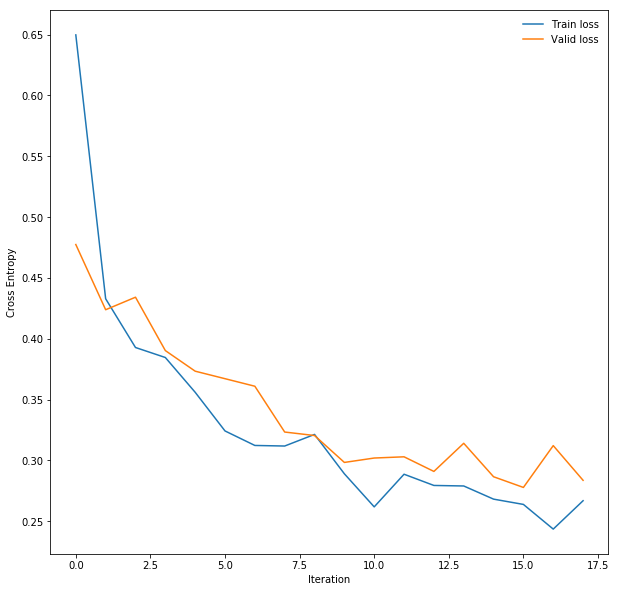

In [73]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Cross Entropy')
plt.plot(train_loss_history, label='Train loss')
plt.plot(valid_loss_history, label='Valid loss')
plt.legend(frameon=False)

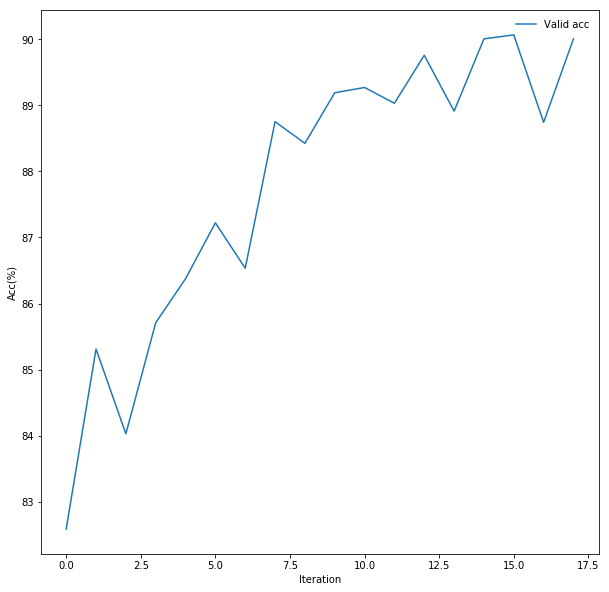

In [74]:
fig = plt.figure(figsize=(10, 10))
plt.plot(valid_acc_history, label='Valid acc')
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Acc(%)')
plt.legend(frameon=False)

---

## Results evaluation

In [75]:
conv_neural_net.eval()
conv_neural_net.use_softmax = True

### View single images and predictions

In [76]:
from image_processing_workshop.visual import plot_classify, plot_image

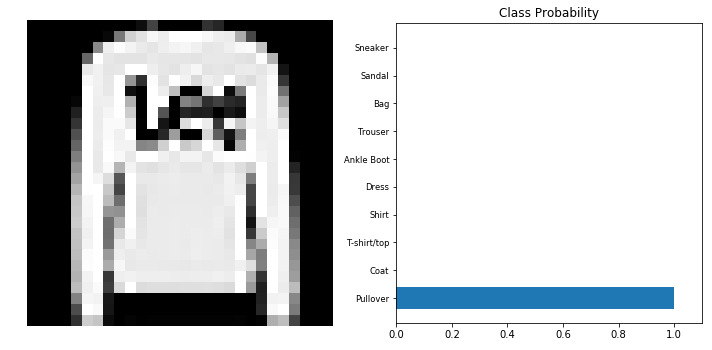

In [78]:
plot_classify(valid_dataset[1][0], conv_neural_net)

### Load reuslts to pandas df

In [79]:
from image_processing_workshop.eval import get_results_df
from image_processing_workshop.visual import plot_df_examples

In [80]:
df = get_results_df(conv_neural_net, valid_loader)
df.head(10)

,label_class_name,label_class_score,predicted_class_name_top1,predicted_class_score_top1,image
0,Ankle boot,0.999472,Ankle boot,0.999472,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,Pullover,0.999343,Pullover,0.999343,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,Trouser,0.999993,Trouser,0.999993,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,Trouser,0.999963,Trouser,0.999963,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,Shirt,0.780411,Shirt,0.780411,"[[[0.0, 0.0, 0.0, 0.007843137718737125, 0.0, 0..."
5,Trouser,0.999861,Trouser,0.999861,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
6,Coat,0.922323,Coat,0.922323,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
7,Shirt,0.864381,Shirt,0.864381,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
8,Sandal,0.986543,Sandal,0.986543,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
9,Sneaker,0.999829,Sneaker,0.999829,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


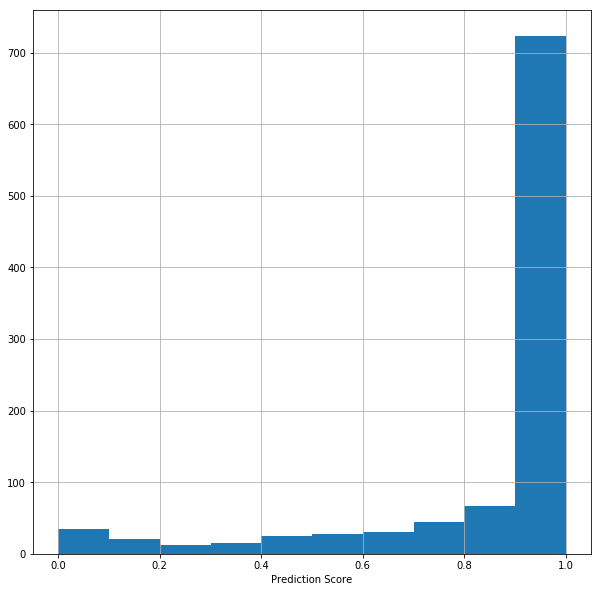

In [81]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Prediction Score')
df[df.label_class_name=='Dress'].label_class_score.hist(ax=ax)

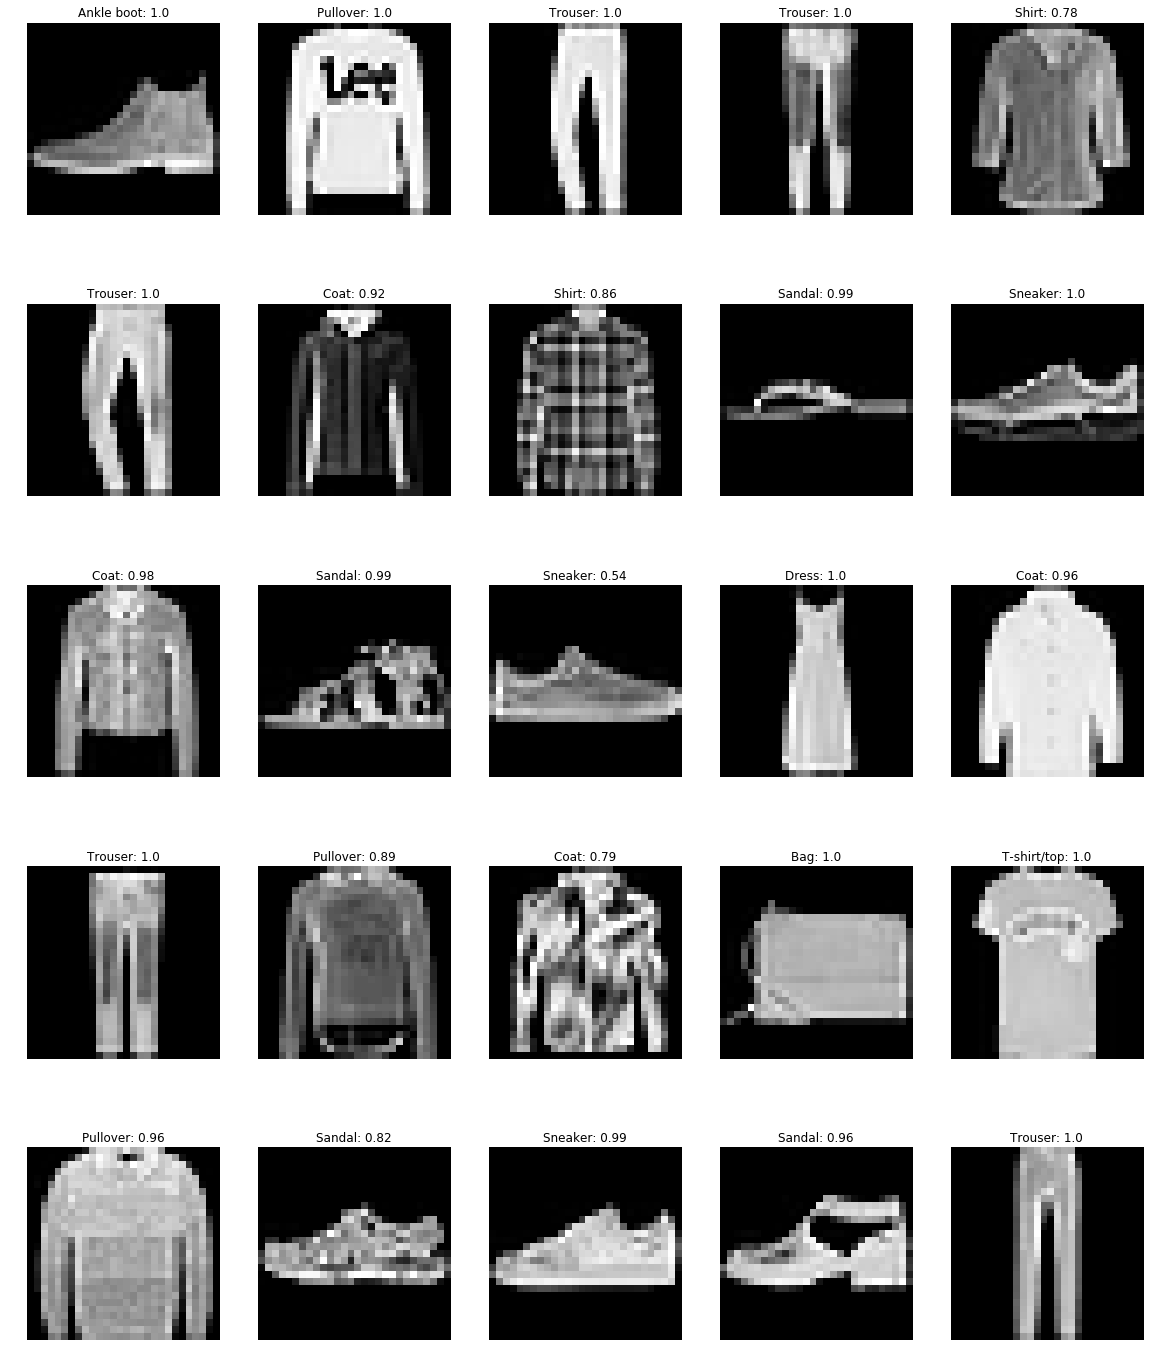

In [82]:
plot_df_examples(df.iloc[:25])

### Precision

In [83]:
from image_processing_workshop.eval import get_precision

In [84]:
get_precision(df, 'Dress')

89.07

### Recall

In [85]:
from image_processing_workshop.eval import get_recall

In [86]:
get_recall(df, 'Dress')

91.3

### Overall Recall and Precision

In [87]:
from image_processing_workshop.eval import get_rec_prec

In [88]:
get_rec_prec(df)

,class_name,recall,precision
0,T-shirt/top,91.2,77.42
1,Trouser,96.9,99.59
2,Pullover,87.1,81.17
3,Dress,91.3,89.07
4,Coat,85.7,82.88
5,Sandal,96.3,98.67
6,Shirt,58.2,81.17
7,Sneaker,92.9,95.97
8,Bag,97.7,98.29
9,Ankle boot,98.3,92.56


### Accuracy

In [89]:
from image_processing_workshop.eval import get_accuracy

In [90]:
get_accuracy(df)

89.56

### False Positives


In [91]:
from image_processing_workshop.eval import get_false_positives

In [92]:
fp = get_false_positives(df, label_class_name='Shirt')

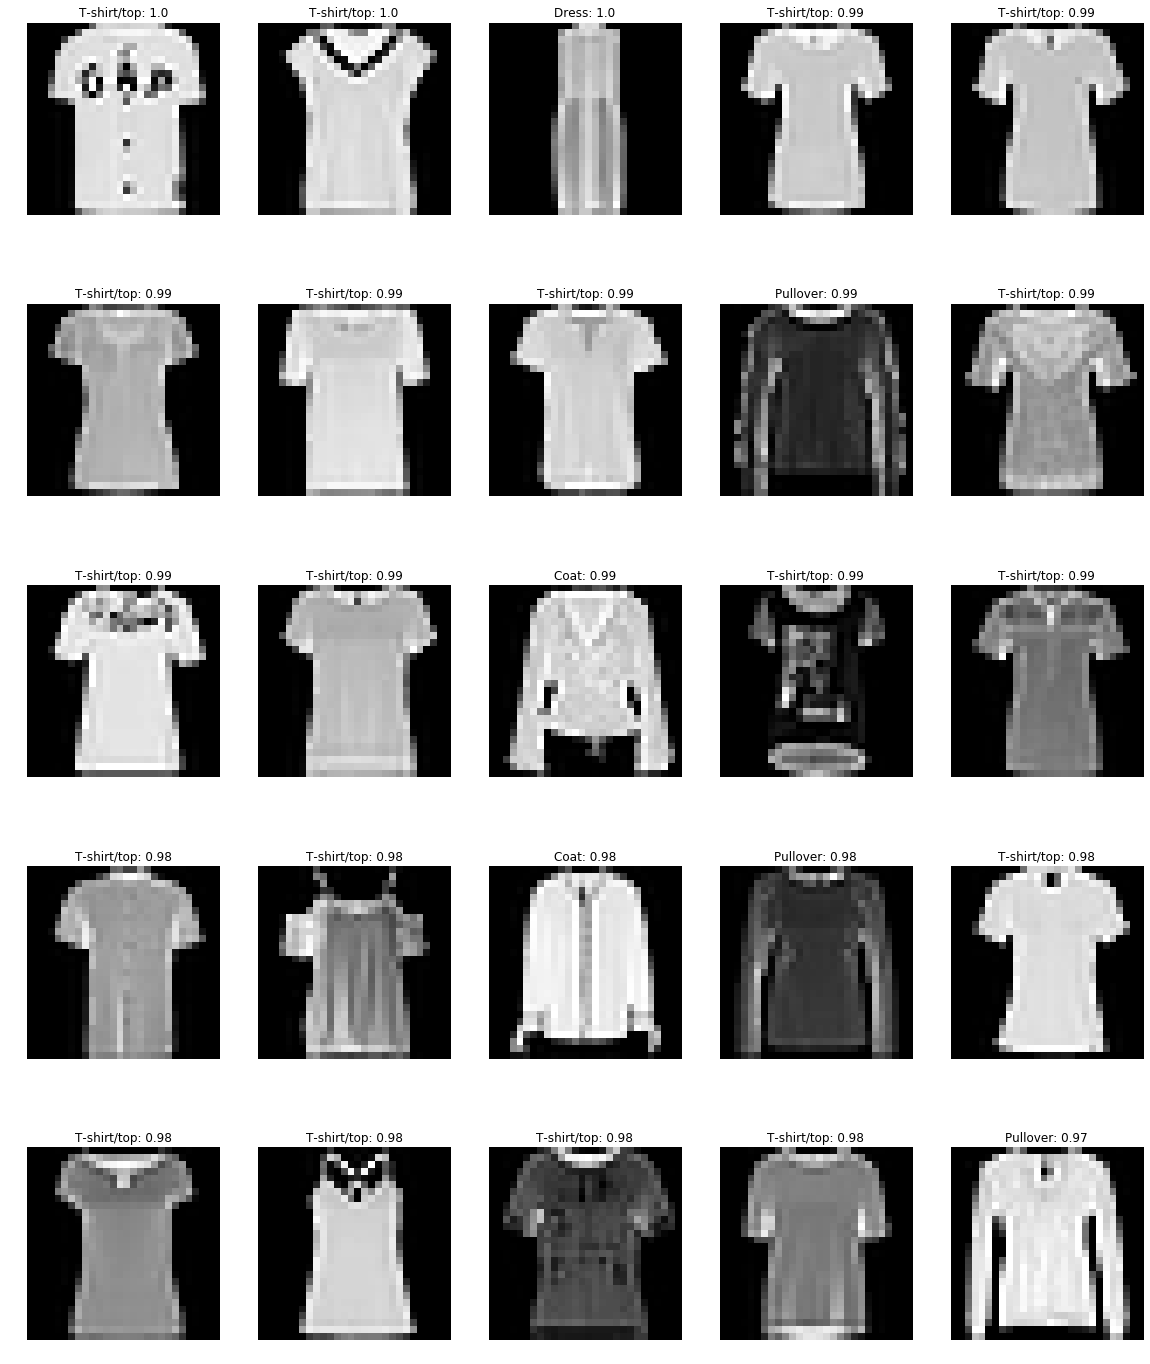

In [93]:
plot_df_examples(fp)

In [94]:
fp = get_false_positives(df, label_class_name='Shirt', predicted_class_name='Pullover')

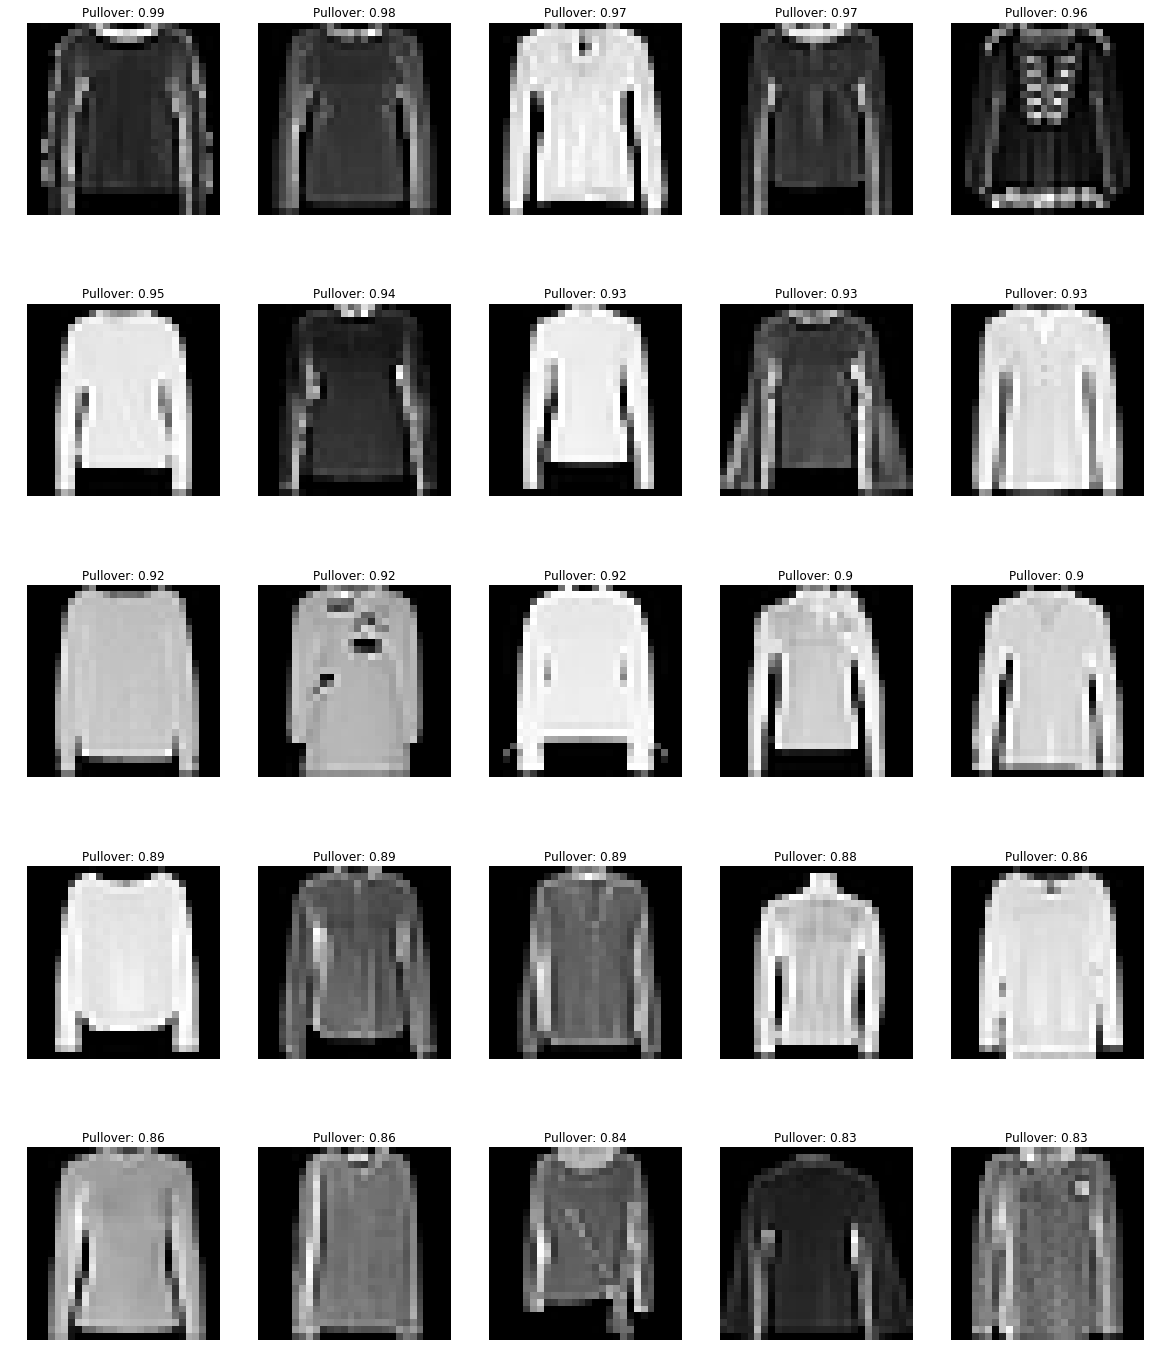

In [95]:
plot_df_examples(fp)

### Confusion Matrix

In [96]:
from image_processing_workshop.visual import plot_coocurance_matrix

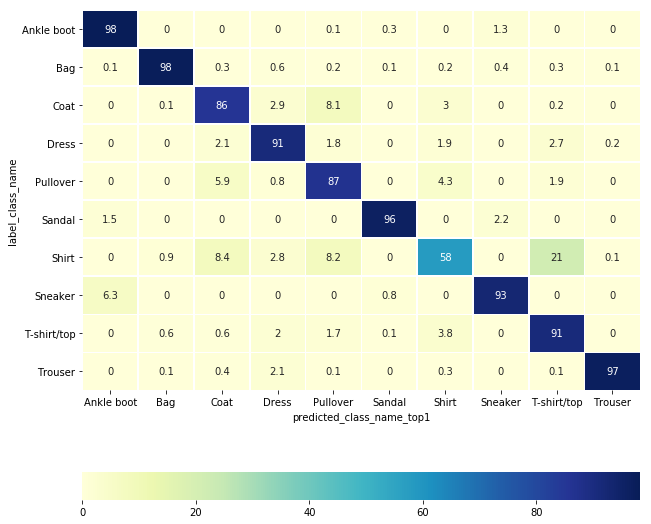

In [97]:
plot_coocurance_matrix(df, use_log=False)